## Load Dataset

In [1]:
import torchvision as thv
import os
import pickle
from torch.utils.data import Subset
import numpy as np

def get_mnist_dataset(root='./mnist_data'):
    # Check if the dataset already exists locally
    if os.path.exists(f'{root}/train_data.pkl') and os.path.exists(f'{root}/val_data.pkl'):
        print("Loading MNIST dataset from local storage...")
        with open(f'{root}/train_data.pkl', 'rb') as f:
            train = pickle.load(f)
        with open(f'{root}/val_data.pkl', 'rb') as f:
            val = pickle.load(f)
    else:
        print("Downloading MNIST dataset...")
        # Download the dataset
        train = thv.datasets.MNIST(root, download=True, train=True)
        val = thv.datasets.MNIST(root, download=True, train=False)
        
        # Save the dataset locally
        os.makedirs(root, exist_ok=True)
        with open(f'{root}/train_data.pkl', 'wb') as f:
            pickle.dump(train, f)
        with open(f'{root}/val_data.pkl', 'wb') as f:
            pickle.dump(val, f)

    print(f"Training dataset shape: {train.data.shape}, Number of targets: {len(train.targets)}")
    print(f"Validation dataset shape: {val.data.shape}, Number of targets: {len(val.targets)}")

    return train, val
    
def split_dataset(train, val):
    import torch
    import numpy as np
    from torch.utils.data import Subset

    # Define the number of classes and target sizes
    num_classes = 10
    target_train_size = 30000
    target_val_size = 5000

    # Initialize lists to hold the indices for the refined datasets
    train_indices = []
    val_indices = []

    # Iterate over each class and collect indices for the split
    for i in range(num_classes):
        # Get indices of all examples from class i in the training and validation sets
        train_class_indices = (train.targets == i).nonzero(as_tuple=True)[0]
        val_class_indices = (val.targets == i).nonzero(as_tuple=True)[0]

        # Convert indices to numpy arrays for shuffling
        train_class_indices_np = train_class_indices.numpy()
        val_class_indices_np = val_class_indices.numpy()

        # Shuffle indices
        np.random.shuffle(train_class_indices_np)
        np.random.shuffle(val_class_indices_np)

        # Calculate split indices, initially aiming to round up
        split_idx_train = (len(train_class_indices_np) + 1) // 2
        split_idx_val = (len(val_class_indices_np) + 1) // 2

        # Adjust split to avoid exceeding overall target sizes
        if len(train_indices) + split_idx_train > target_train_size:
            split_idx_train = target_train_size - len(train_indices)
        if len(val_indices) + split_idx_val > target_val_size:
            split_idx_val = target_val_size - len(val_indices)

        # Add indices to lists
        train_indices.extend(train_class_indices_np[:split_idx_train])
        val_indices.extend(val_class_indices_np[:split_idx_val])

        # Check if we have already reached the target sizes
        if len(train_indices) == target_train_size and len(val_indices) == target_val_size:
            break

    # Create refined datasets
    refined_train = Subset(train, train_indices)
    refined_val = Subset(val, val_indices)

    print(f"Refined training dataset size: {len(refined_train)}")
    print(f"Refined validation dataset size: {len(refined_val)}")

    return refined_train, refined_val

In [2]:
data_path = "./prob3_mnist_data"

train, val = get_mnist_dataset(data_path)
refined_train, refined_val = split_dataset(train, val)

print("Train", train)
print("Val", val)
print("Refined Train", refined_train)
print("Refined Val", refined_val)

Loading MNIST dataset from local storage...
Training dataset shape: torch.Size([60000, 28, 28]), Number of targets: 60000
Validation dataset shape: torch.Size([10000, 28, 28]), Number of targets: 10000
Refined training dataset size: 30000
Refined validation dataset size: 5000
Train Dataset MNIST
    Number of datapoints: 60000
    Root location: ./prob3_mnist_data
    Split: Train
Val Dataset MNIST
    Number of datapoints: 10000
    Root location: ./prob3_mnist_data
    Split: Test
Refined Train <torch.utils.data.dataset.Subset object at 0x000001791262E670>
Refined Val <torch.utils.data.dataset.Subset object at 0x000001791262E2E0>


In [3]:
# Normalize the data
mean = train.data.float().mean() / 255.0
std = train.data.float().std() / 255.0
print(f"Mean: {mean}, Std: {std}")

transform = thv.transforms.Compose([
    thv.transforms.ToTensor(),
    thv.transforms.Normalize(mean=(mean,), std=(std,))
])

train = thv.datasets.MNIST(data_path, download=True, train=True, transform=transform)
val = thv.datasets.MNIST(data_path, download=True, train=False, transform=transform)
refined_train = thv.datasets.MNIST(data_path, download=True, train=True, transform=transform)
refined_val = thv.datasets.MNIST(data_path, download=True, train=False, transform=transform)


Mean: 0.13066047430038452, Std: 0.30810779333114624


## Plot and Validate Dataset

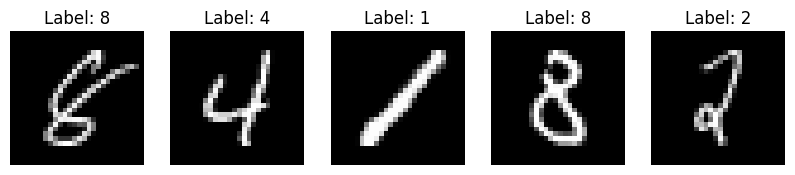

In [4]:
import matplotlib.pyplot as plt
import torch

def plot_images(dataset, num_images=6):
    # Making sure the dataset can be indexed directly
    assert hasattr(dataset, '__getitem__'), "Dataset must support indexing"

    indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    
    if num_images == 1:
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        
        # MNIST images are 1-channel images, need to be reshaped if in tensor form
        if isinstance(image, torch.Tensor):
            image = image.numpy().squeeze()  # Convert to numpy and remove extra dimensions
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.show()

plot_images(refined_train, num_images=5)

## Linear Layer

### Forward function
For $\beta$ samples, $\alpha$ input features, and $c$ output features, the forward function is 
$$h^{(l+1)} = h^{(l)} W^{\top} + b$$
where: $h^l \in R^{\beta \times \alpha}$, $W \in R^{c \times \alpha}$, $b \in R^c$, $h^{l+1} \in R^{\beta \times c}$

### Backward function:
$$\frac{\partial L}{\partial h^l} = \frac{\partial L}{\partial h^{l+1}} W$$
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial h^{l+1}}^{\top} h^l$$
$$\frac{\partial L}{\partial b} = \sum_{i=1}^\beta \frac{\partial L}{\partial h_i^{l+1}}$$
where: $\frac{\partial L}{\partial h^{l+1}} \in R^{\beta \times c}$, $\frac{\partial L}{\partial W} \in R^{c \times \alpha}$, $\frac{\partial L}{\partial b} \in R^c$



## ReLU Layer

### Forward function
$$h^{(l+1)} = \max(0, h^{(l)})$$
where: $h^l \in R^{\beta \times \alpha}$, $h^{(l+1)} \in R^{\beta \times \alpha}$

### Backward function
$$\frac{\partial L}{\partial h^l} = \frac{\partial L}{\partial h^{l+1}} \odot \mathbb{1}(h^l > 0)$$
where: $\odot$ is element-wise multiplication, $\mathbb{1}$ is the indicator function

## Combined Softmax and Cross-entropy Loss Layer

### Forward function
$$h_k^{(l+1)} = \frac{e^{h_k^{(l)}}}{\sum_{k'} e^{h_{k'}^{(l)}}}$$
$$l(y) = -\log(h_y^{(l+1)})$$
For a mini-batch of size $\beta$, the loss is
$$l({y_i}_{i=1,...,\beta}) = -\frac{1}{\beta} \sum_{i=1}^{\beta} \log(h_y^{(l+1)})$$

Error is
$$\text{error} = \frac{1}{\beta} \sum_{i=1}^{\beta} \mathbb{1}(y \neq \text{argmax}_k(h_k^{(l+1)}))$$

### Backward function
$$\frac{\partial L}{\partial h^{(l)}} = \frac{1}{\beta} \sum_{i=1}^{\beta} \frac{\partial l(y_i)}{\partial h^{(l)}}$$
where: $\frac{\partial l(y_i)}{\partial h^{(l)}} = h^{(l+1)} - \mathbb{1}(y_i)$


## Check the backward pass of all three layers

In [5]:
from layers import linear_t

lin = linear_t(alpha=3, c=4)
h_l = np.array([[0.5, 1.5, 2.5], [-0.5, -1.5, -2.5]])  # alpha = 3, beta = 2
dh_lp1 = np.array([[0.1, 1, 2, 10], [0.1, 1, 2, 10]])  # c = 4, beta = 2
lin.W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])  # c = 4, alpha = 3

h_lp1 = lin.forward(h_l)
lin.zero_grad()
dh_l = lin.backward(dh_lp1)

print(h_lp1)
print(dh_l)
print(lin.dW)
print(lin.db)

[[ 11.5  25.   38.5  52. ]
 [-10.5 -24.  -37.5 -51. ]]
[[118.1 131.2 144.3]
 [118.1 131.2 144.3]]
[[ 0.00000000e+00  1.38777878e-17 -1.38777878e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[ 0.2  2.   4.  20. ]


In [6]:
from layers import relu_t

relu = relu_t()
h_l = np.array([[0.5, 1.5, -2.5], [0.5, -1.5, 2.5]])  # alpha = 3, beta = 2
dh_lp1 = np.array([[0.3, 2, 1], [-1, -1, -1]])  

h_lp1 = relu.forward(h_l)
dh_l = relu.backward(dh_lp1)

print(h_lp1)
print(dh_l)

[[0.5 1.5 0. ]
 [0.5 0.  2.5]]
[[ 0.3  2.   0. ]
 [-1.  -0.  -1. ]]


In [7]:
from layers import softmax_cross_entropy_t

# Single sample
sce = softmax_cross_entropy_t()
h_l = np.array([1, 2, 3])
y = np.array([2])
dh_lp1 = np.array([0.1, 1, 2])

h_lp1, ell, error = sce.forward(h_l, y)
dh_l = sce.backward(dh_lp1, y)

print("\nSingle sample")
print(h_lp1)
print(ell)
print(error)
print(dh_l)

# Batched samples
sce = softmax_cross_entropy_t()
h_l = np.array([[1, 2, 3], [2, -1, 3]])
y = np.array([2, 1])
dh_lp1 = np.array([[0.1, 1, 2], [0.1, 1, 2]])

h_lp1, ell, error = sce.forward(h_l, y)
dh_l = sce.backward(dh_lp1, y)

print("\nBatched")
print(h_lp1)
print(ell)
print(error)
print(dh_l)


Single sample
[[0.09003057 0.24472847 0.66524096]]
0.40760596444438046
0.0
[[ 0.09003057  0.24472847 -0.33475904]]

Batched
[[0.09003057 0.24472847 0.66524096]
 [0.26538793 0.01321289 0.72139918]]
2.3670843028559254
0.5
[[ 0.04501529  0.12236424 -0.16737952]
 [ 0.13269396 -0.49339356  0.36069959]]


### Since all three layers have been validated and compared with PyTorch, we can continue to (f)

## Training

In [8]:
# Helper functions for visualization

import matplotlib.pyplot as plt
from ipywidgets import Output

# Helper functions to plot loss and error using a separate Output widget
def plot_loss_error(val_error_results, val_loss_results, plot_output):
    """
    Plots the validation error and validation loss over iterations.
    Updates the plot in the provided Output widget.

    Args:
        val_error_results (list): List of validation error values over iterations.
        val_loss_results (list): List of validation loss values over iterations.
        plot_output (Output): IPython Output widget to render the plots.
    """
    iterations = list(range(0, len(val_loss_results) * 1000, 1000))  # Assuming evaluation every 1000 steps

    with plot_output:
        # Clear the previous plot to avoid stacking
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Plot Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(iterations, val_loss_results, label='Validation Loss', color='blue', marker='o')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Validation Loss over Iterations')
        plt.grid(True)
        plt.legend()

        # Plot Validation Error
        plt.subplot(1, 2, 2)
        plt.plot(iterations, val_error_results, label='Validation Error', color='red', marker='o')
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.title('Validation Error over Iterations')
        plt.grid(True)
        plt.legend()

        # Adjust layout and show the updated plots
        plt.tight_layout()
        plt.show()
        
# Function to print validation metrics using a separate Output widget
def print_validation_metrics(val_loss, val_error, validation_output):
    """
    Prints the validation loss and error in the provided Output widget.

    Args:
        val_loss (float): The validation loss.
        val_error (float): The validation error rate.
        validation_output (Output): IPython Output widget to render the validation metrics.
    """
    with validation_output:
        # Move to new line
        print(f"Validation Loss: {val_loss:.4f}, Validation Error: {val_error:.4f}")

### NumPy Implementation

In [ ]:
## NumPy Implementation
from IPython.display import clear_output
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
from IPython.display import display, HTML

# Initialize all the layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]

lr = 0.1
max_iters = 10000
# np.random.seed(42)

process_bar = tqdm(range(max_iters))

# Train for at least 1000 iterations
for t in range(max_iters):
    # 1. Sample a mini-batch of size = 32
    # Each image in the mini-batch is chosen uniformly randomly from the training dataset
    # Access an image and its label using: image, label = refined_train[idx]

    # Extract 32 random indices
    indices = np.random.choice(len(refined_train), 32, replace=False)

    # Extract the images and labels
    images_list = [np.array(refined_train[idx][0]) for idx in indices]  # PIL imgs to numpy arrays (28x28 each)
    labels_list = [refined_train[idx][1] for idx in indices]

    # Convert to numpy arrays
    x = np.array(images_list).reshape(32, -1)  # numpy array of shape (32, 784)
    y = np.array(labels_list).reshape(32, -1)  # numpy array of shape (32,)
    
    # 2. Zero gradient buffer
    for l in net:
        l.zero_grad()
    
    # 3. Forward pass
    h1 = l1.forward(x)  # (32, 10), l1.W: (10, 784), l1.b: (10,)
    h2 = l2.forward(h1)  # (32, 10)
    _, ell, error = l3.forward(h2, y)  # (32, 10), scalar, scalar, l3.y: (32, 1), l3.h and l3.h_lp1: (32, 10)
    
    # 4. Backward pass
    dh2 = l3.backward()  # (32, 10)
    dh1 = l2.backward(dh2)  # (32, 10)
    dx = l1.backward(dh1)  # (32, 784)
    
    # 5. Gather backprop gradients
    dW, db = l1.dW, l1.db  # (10, 784), (10,)
    
    # 6. Print some quantities for logging and debugging
    process_bar.update(1)
    # print(t, ell, error)
    # print(t, np.linalg.norm(dW/l1.W), np.linalg.norm(db/l1.b))
    print(f"\rIteration: {t:4d}, Loss: {ell:.4f}, Error: {error:.4f}, "
          f"dW/W Norm: {np.linalg.norm(dW/l1.W):.4f}, db/b Norm: {np.linalg.norm(db/l1.b):.4f}" + " "*20, end="")
    
    # 7. One step of SGD
    l1.W = l1.W - lr * dW
    l1.b = l1.b - lr * db

    # 8. Every 1000 iterations, evaluate the model on the validation set
    if t % 1000 == 0:
        # Evaluate the model on the validation set
        val_losses = []
        val_errors = []
        for idx in range(len(refined_val)):
            x_val = np.array(refined_val[idx][0]).reshape(1, -1)
            y_val = np.array(refined_val[idx][1]).reshape(1, -1)

            h1_val = l1.forward(x_val)
            h2_val = l2.forward(h1_val)
            _, ell_val, error_val = l3.forward(h2_val, y_val)

            val_losses.append(ell_val)
            val_errors.append(error_val)

        # Compute the average loss and error
        val_loss = np.mean(val_losses)
        val_error = np.mean(val_errors)

        # Print the validation loss and error
        print(f"\nValidation Loss: {val_loss:.4f}, Validation Error: {val_error:.4f}")

        # Plot the validation loss and error
        plot_loss_error(val_loss, val_error)

        # Early stopping conditions
        if val_loss < 0.1:
            print("\nStopping training as validation loss is below 0.1")
            break
        if val_error < 0.05:
            print("\nStopping training as validation error is below 0.05")
            break

# Close the progress bar when done
process_bar.close()


### PyTorch Implementation


In [10]:
# PyTorch Comparison
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ExponentialLR
from IPython.display import clear_output, display
from IPython.display import display, HTML


# Random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Initialize layers
l1_torch, l2_torch, l3_torch = nn.Linear(784, 10), nn.ReLU(), nn.CrossEntropyLoss()
net_torch = [l1_torch, l2_torch, l3_torch]

# Learning settings
lr = 0.1
lr_decay_rate = 0.99998
max_iters = 10000
optimizer = torch.optim.SGD(l1_torch.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=lr_decay_rate)

# Create separate Output widgets for plotting and printing validation metrics
plot_output = Output()
validation_output = Output()
display(plot_output)
display(validation_output)

process_bar = tqdm(range(max_iters))
val_error_results = []
val_loss_results = []

# Train iteration
for t in range(max_iters):
    process_bar.update(1)
    # 1. Sample a mini-batch of size = 32
    indices = np.random.choice(len(refined_train), 32, replace=False)
    # images_list = [torch.tensor(np.array(refined_train[idx][0]).reshape(-1), dtype=torch.float32) for idx in indices]
    images_list = [torch.tensor(np.asarray(refined_train[idx][0]).reshape(-1), dtype=torch.float32) for idx in indices]
    labels_list = [torch.tensor(refined_train[idx][1], dtype=torch.long) for idx in indices]
    x = torch.stack(images_list)  # (32, 784)
    y = torch.stack(labels_list)  # (32,)
    
    # 2. Zero gradient buffer
    optimizer.zero_grad()
    
    # 3. Forward pass
    h1 = l1_torch(x)  # (32, 10)
    h2 = l2_torch(h1)  # (32, 10)
    ell = l3_torch(h2, y)  # scalar
    
    # 4. Backward pass
    ell.backward()
    
    # 5. Print some quantities for logging and debugging
    # print(t, ell.item())
    # print(t, torch.norm(l1.weight.grad / l1.weight), torch.norm(l1.bias.grad / l1.bias))
    current_lr = optimizer.param_groups[0]['lr']
    # log_message = (f"Iteration: {t:4d}, Learning Rate: {current_lr:.6f}, Loss: {ell.item():.4f}, "
    #                f"dW/W Norm: {torch.norm(l1.weight.grad / l1.weight):.4f}, "
    #                f"db/b Norm: {torch.norm(l1.bias.grad / l1.bias):.4f}")
    # print(log_message, end="\r")  # Print the log message without clearing tqdm progress bar
    process_bar.set_description(
        f"Iter: {t:4d}, LR: {current_lr:.6f}, Loss: {ell.item():.4f}, "
        f"dW/W Norm: {torch.norm(l1_torch.weight.grad / l1_torch.weight).item():.4f}, "
        f"db/b Norm: {torch.norm(l1_torch.bias.grad / l1_torch.bias).item():.4f}"
    )
    
    # 6. One step of SGD
    optimizer.step()

    # 7. Step the scheduler to adjust the learning rate
    scheduler.step()

    # 8. Every 1000 iterations, evaluate the model on the validation set
    if t % 1000 == 0 and t > 1:
        # Evaluate the model on the validation set
        val_losses = []
        val_errors = []
        with torch.no_grad():
            for idx in range(len(refined_val)):
                # x_val = torch.tensor(np.array(refined_val[idx][0]).reshape(-1), dtype=torch.float32).unsqueeze(0)
                x_val = torch.tensor(np.asarray(refined_val[idx][0]).reshape(-1), dtype=torch.float32).unsqueeze(0)
                y_val = torch.tensor(refined_val[idx][1], dtype=torch.long).unsqueeze(0)

                h1_val = l1_torch(x_val)
                h2_val = l2_torch(h1_val)
                ell_val = l3_torch(h2_val, y_val)

                val_losses.append(ell_val.item())
                val_errors.append((h2_val.argmax(dim=1) != y_val).item())

        # Compute the average loss and error
        val_loss = np.mean(val_losses)
        val_error = np.mean(val_errors)
        val_error_results.append(val_error)
        val_loss_results.append(val_loss)

        # Plot the validation loss and error
        plot_loss_error(val_error_results, val_loss_results, plot_output)

        # Print the validation loss and error below the progress bar
        print_validation_metrics(val_loss, val_error, validation_output)

        # Early stopping conditions
        if val_loss < 0.1:
            with validation_output:
                print("\nStopping training as validation loss is below 0.1")
            break
        if val_error < 0.05:
            with validation_output:
                print("\nStopping training as validation error is below 0.05")
            break

# Close the progress bar when done
process_bar.close()
    

Output()

Output()

  0%|          | 0/10000 [00:00<?, ?it/s]

## Validation

In [13]:
# For NumPy Implementation
def validate_numpy(w, b):
    # TODO
    # 1. Iterate over mini-batches from the validation dataset
    # Note that this should not be done randomly , we want to check every image only once
    loss, tot_error = 0, 0
    for i in range(0, 5000, 32):
        x, y = refined_val.data[i:i+32], refined_val.targets[i:i+32]
    
    # 2. Compute forward pass and error
    h1 = l1.forward(x)  # (32, 10)
    h2 = l2.forward(h1)  # (32, 10)
    _, ell, error = l3.forward(h2, y)  # (32, 10), scalar, scalar, l3.y: (32, 1), l3.h and l3.h_lp1: (32, 10)

    # 3. Accumulate loss and error
    loss += ell
    tot_error += error

    return loss, tot_error

# For PyTorch Implementation
def validate_pytorch(w, b):
    # TODO
    # 1. Iterate over mini-batches from the validation dataset
    # Note that this should not be done randomly , we want to check every image only once
    loss, tot_error = 0, 0
    for i in range(0, 5000, 32):
        x, y = refined_val.data[i:i+32], refined_val.targets[i:i+32]
    
    # 2. Compute forward pass and error
    h1 = l1.forward(x)  # (32, 10)
    h2 = l2.forward(h1)  # (32, 10)
    _, ell, error = l3.forward(h2, y)  # (32, 10), scalar, scalar, l3.y: (32, 1), l3.h and l3.h_lp1: (32, 10)

    # 3. Accumulate loss and error
    loss += ell
    tot_error += error

    return loss, tot_error
